In [85]:
import re
import string
import gc
import os
import shutil
from datetime import datetime
import time
from pathlib import Path
import random
import joblib

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
import torch
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, AutoConfig, get_cosine_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset, DatasetDict

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from lightgbm import LGBMRegressor, Booster

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
print(torch.__version__)

1.12.1+cu113


# Common Utils

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
def on_gpu(f):
    def wrapper():
        if torch.cuda.is_available():
            return f()
        else:
            print('cuda unavailable')
    return wrapper

In [ ]:
if torch.cuda.is_available():
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization():
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache():
    print("Initial GPU Usage")
    print_gpu_utilization()                          

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization()
    
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
def to_train_test_splits_task(X_train, X_test, y_train, y_test, label):
    y_train[f'{label}_labels'] = y_train[label].apply(lambda x: REV_LABELS[x])
    y_test[f'{label}_labels'] = y_test[label].apply(lambda x: REV_LABELS[x])

    train_split = pd.concat([X_train, y_train], axis=1)
    test_split = pd.concat([X_test, y_test], axis=1)
    return train_split, test_split

def gaussian(x, T):
    return x * np.exp(- 5 * np.power(1 - T, 2))

def match_with_batchsize(lim, batchsize):
    """
    Function used by modify_datasets below to match return the integer closest to lim
    which is multiple of batchsize, i.e., lim%batchsize=0.

    """

    if lim % batchsize == 0:
        return lim
    else:
        return lim - lim % batchsize

# Metrics and evaluation Utils

In [ ]:
def MCRMSE(actual, predicted):
    squared_diff = (actual - predicted)**2
    sqrt_mean = np.sqrt(np.mean(squared_diff, axis=0))
    return np.mean(sqrt_mean)

def MCRMSE_scores(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        score = mean_squared_error(y_true, y_pred, squared = False)
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    predictions = np.argmax(logits[0], axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions), 
        'rmse': np.sqrt(mean_squared_error(decode(labels), decode(predictions)))
        }

def decode(predictions):
    return np.array(list(map(lambda x: RAW_LABELS[x], predictions)))

# Training Utils

In [ ]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def get_checkpoint(task):
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    if os.path.exists(f'{chckpt_path}/final'):
        return f'{chckpt_path}/final'
    elif os.path.exists(chckpt_path):
        checkpoints = list(filter(lambda x: x.startswith('checkpoint-'), os.listdir(chckpt_path)))
        checkpoints.sort(reverse=False)
        if len(checkpoints) == 0:
            return MODEL_NAME
        return f'{chckpt_path}/{checkpoints[0]}'
    return MODEL_NAME

def is_trained(task):
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    if os.path.exists(chckpt_path) and os.path.exists(f'{chckpt_path}/trained'):
        return True
    return False

def clean_checkpoints(task, keep=1):
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    checkpoints = list(filter(lambda x: x.startswith('checkpoint-'), os.listdir(chckpt_path)))
    checkpoints.sort(reverse=False)
    for chckpt in checkpoints[keep:]:
        print('removing...', f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/{chckpt}')
        shutil.rmtree(f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/{chckpt}', ignore_errors=True)

def retrain(task):
    model_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    print('removing...', model_path)
    shutil.rmtree(model_path, ignore_errors=True)

def freeze(model):
    for name, param in model.named_parameters():
        if 'transformer.layer.0' in name or 'word_embeddings' in name:
            param.requires_grad = False
    return model

def unfreeze(model):
    for name, param in model.named_parameters():
        if 'transformer.layer.0' in name or 'word_embeddings' in name:
            param.requires_grad = False
    return model

# Tokenization utils

In [ ]:
def tokenization(example):
    return tokenizer(example['text'], 
                    max_length=512, 
                    padding='max_length', 
                    truncation=True, 
                    add_special_tokens=True,
                    return_tensors='pt')

def tokenize(example):
    return tokenizer(example, 
                    max_length=512, 
                    padding='max_length', 
                    truncation=True, 
                    add_special_tokens=True,
                    return_tensors='pt')

# Plotting Utils

In [ ]:
def plot_scheduler_stats(stats):
    epochs_x = list(range(1, len(stats['lr_history']) + 1))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(epochs_x, stats['lr_history'])
    ax1.set_title('Learning rates')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('learning_rate')

    ax2.plot(epochs_x, stats['weights_history'])
    ax2.set_title('Weights')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('weight')

    plt.title('Scheduler stats')
    
    plt.show()

# Models load/saving Utils

In [56]:
def get_model_name_or_config_path(task):
    config_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/config.json'
    if os.path.exists(config_path):
        return config_path
    return MODEL_NAME

def get_model_name_or_path(task):
    model_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/final'
    if os.path.exists(model_path):
        return model_path
    return MODEL_NAME

def save_model_reg(fold, model):
    print('Saving model...')
    try:
        Path(f'{BASIC_PATH}/models/{MODEL_REG}').mkdir(parents=True, exist_ok=True)
        joblib.dump(model, f'{BASIC_PATH}/models/{MODEL_REG}/fold_{fold}.pkl')
    except Exception as e:
        print(e)

def get_model_reg(fold):
    return joblib.load(f'{BASIC_PATH}/models/{MODEL_REG}/fold_{fold}.pkl')

def save_model_task(task, model):
    print('Saving model...')
    try:
        Path(f'{BASIC_PATH}/models/{MODEL_NAME}/{task}').mkdir(parents=True, exist_ok=True)
        torch.save(model.cpu().state_dict(), f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/final')
        model.config.save_pretrained(f'{BASIC_PATH}/models/{MODEL_NAME}/{task}')
    except Exception as e:
        print(e)

In [ ]:
print_gpu_utilization()
free_gpu_cache()

GPU memory occupied: 3 MB.
Initial GPU Usage
GPU memory occupied: 3 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3 MB.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
BASIC_PATH = 'gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning'

In [ ]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
aug_data = pd.read_csv(f'{BASIC_PATH}/data/aug_data.csv')
train_data

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
TARGET_VARIABLES = list(train_data.columns[2:])
TARGET_VARIABLES

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
X, y = train_data['full_text'], pd.concat([train_data['text_id'], train_data.iloc[:, 2:]], axis=1)
X

0       I think that students would benefit from learn...
1       When a problem is a change you have to let it ...
2       Dear, Principal\n\nIf u change the school poli...
3       The best time in life is when you become yours...
4       Small act of kindness can impact in other peop...
                              ...                        
3906    I believe using cellphones in class for educat...
3907    Working alone, students do not have to argue w...
3908    "A problem is a chance for you to do your best...
3909    Many people disagree with Albert Schweitzer's ...
3910    Do you think that failure is the main thing fo...
Name: full_text, Length: 3911, dtype: object

In [ ]:
y

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...
3906,FFD29828A873,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
RAW_LABELS = {label: key for label, key in zip(range(0, 10), np.arange(1.0, 5.5, 0.5))}
REV_LABELS = {v: k for k, v in RAW_LABELS.items()}

In [ ]:
RAW_LABELS, REV_LABELS

({0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5, 4: 3.0, 5: 3.5, 6: 4.0, 7: 4.5, 8: 5.0},
 {1.0: 0, 1.5: 1, 2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6, 4.5: 7, 5.0: 8})

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MODEL_REG = 'lightboost'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Semi-supervised learning model

In [ ]:
class MeanPooling(torch.nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [53]:
class TemporalEnsembleModel(torch.nn.Module):

    """
    Implementation of Temporal ensemble model as introduced in <https://arxiv.org/abs/1610.02242>

    Args:

    alpha (:obj:`float`): memory of the last epochs. For more info please refer
    to <https://arxiv.org/abs/1610.02242>.

    unsup_weight (:obj:`float`): initial value of weight of the unsupervised loss
    component. After setting the initial value, its value is controlled by
    unsupervised weight scheduler.

    kwargs: remaining dictionary of keyword arguments from the BaseModelClass.

    Class attributes:

     -**mini_batch_num**: keeps track of the mini_batch_num using forward method.

     -**logits_batchwise**: stores the logits of each batch passed through forward method.

     -**firstpass**: bool variable to track if its the first pass through the forward method.

    """

    def __init__(self, alpha=0.5, unsup_weight=0, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.config = AutoConfig.from_pretrained(get_model_name_or_config_path(TASK))

        self.config.update({
            'id2label': RAW_LABELS,
            'num_labels': len(RAW_LABELS),
            'label2id': REV_LABELS,
            'output_hidden_states': True,
            'hidden_dropout_prob': 0.1,
            'attention_probs_dropout_prob': 0.1,
            'classifier_dropout': 0.3,
        })

        self.num_labels = len(RAW_LABELS)

        self.base = AutoModelForSequenceClassification.from_pretrained(get_model_name_or_path(TASK), config=self.config)

        self.unsup_weight = unsup_weight
        self.memory_logits = []
        self.alpha = alpha
        self.mini_batch_num = 0
        self.logits_batchwise = []
        self.firstpass = True

        self.pooler = MeanPooling()

    def forward(self, input_ids, attention_mask, *args, **kwargs):
        """
        Implementation of forward function calculating the semi supervised loss.
        Mixing of the labeled and unlabeled examples in a single batch is not allowed.

        Args:

        kwargs: Arguments from pretrained_model.forward.

        Return:
        transformers.modeling_outputs.SequenceClassifierOutput object
        with the information of logits and the loss function.

        """

        labels = kwargs.pop("labels", [])
        out = self.base.forward(input_ids.squeeze(1), attention_mask.squeeze(1), *args, **kwargs)
        logits = out.logits

        sup_loss = torch.nn.CrossEntropyLoss()
        unsup_loss = torch.nn.MSELoss()

        tot_loss = 0
        if len(labels) > 0 and all(labels >= 0):
            tot_loss = sup_loss(logits.view(-1, self.num_labels), labels.view(-1))

        if self.firstpass is False and self.training:
            tot_loss += self.unsup_weight * unsup_loss(self.memory_logits[self.mini_batch_num], logits)

        elif self.training:
            # required to free the graph
            tot_loss += 0 * logits.sum()

        if self.training:
            self.logits_batchwise.append(logits.detach().clone())
            self.mini_batch_num += 1

        return SequenceClassifierOutput(
            hidden_states=self.pooler(out.hidden_states[-1], attention_mask.squeeze(1)),
            loss=tot_loss,
            logits=logits
        )

    def update_memory_logits(self, t):
        """
        Method for updating the memory logits with the exponential average.

        Args:
        t (:obj:`int`): epoch value for bias normalization.

        """
        return
        if self.firstpass is True:

            device = self.logits_batchwise[0].device

            self.memory_logits = [torch.zeros(self.logits_batchwise[0].shape, device=device)
                                  for _ in range(self.mini_batch_num)]
            self.firstpass = False

        for ind in range(self.mini_batch_num):

            self.memory_logits[ind] = (self.alpha * self.memory_logits[ind] +
                                       (1 - self.alpha) * self.logits_batchwise[ind])

            self.memory_logits[ind] /= (1 - self.alpha**(t) + 1e-8)

        self.mini_batch_num = 0
        self.logits_batchwise[:] = []


In [ ]:
class UWScheduler:

    """
    Unsupervised weights scheduler for changing the unsupervised weight
    of the semi supervised learning models. Also contains methods any
    other kinds variables updates required by the models. For example,
    PiModel, TemporalEnsembling model, and Mean Teacher. In this implementation,
    it's  based on the composition with learning scheduler from pytorch and it
    works best ~transformers.Trainer without having to rewrite train method.
    # TODO: cleaner version with the rewritten Trainer.train method.

    Args:

    lr_scheduler (:obj:`torch.optim.lr_scheduler`): Learning scheduler object.

    trainer (:obj:`~TrainerWithUWScheduler`): Trainer object.

    unsup_start_epochs (:obj:`int`): value of epoch at which the unsupervised
    weights should start updating.

    max_w (:obj:`float`): maximum value of weight that the unsup_weight from model
    could reach.

    update_teacher_steps (:obj:`int`): useful for MeanTeacher, sets the interval after
    which teacher variables should be updated.

    w_ramprate (:obj:`float`): linear rate at which the unsupervised weight would be
    increased from the initial value.

    update_weights_steps (:obj:`int`): interval steps after which unsupervised weight
    would be updated by the w_ramprate.

    Class attributes:

    -**step_in_epochs**: Number of steps (batch passes) in an epoch.

    -**local_step**: keeps track of the times unsupervised weight has been changed.

    """

    def __init__(self, lr_scheduler, trainer, unsup_start_steps=0, max_w=1,
                 w_ramprate=1, update_weights_steps=1):

        self.trainer = trainer
        self.lr_scheduler = lr_scheduler
        self.local_step = 0
        self.max_w = max_w
        self.unsup_start_steps = unsup_start_steps
        self.update_weights_steps = update_weights_steps
        self.w_ramprate = w_ramprate
        self.steps_in_epoch = len(self.trainer.train_dataset) // self.trainer.args.train_batch_size

        # debug
        self.weight_history = []
        self.lr_history = []

    def step(self):
        """
        Implementation of composition of the pytorch learning rate scheduler step function
        with schedule of unsupervised weights. 

        """

        self.lr_scheduler.step()

        # trainer.state.num_train_epochs is unavailable in the init...
        expected_steps = self.steps_in_epoch * self.trainer.state.num_train_epochs
        T = 1.0 / (expected_steps - self.unsup_start_steps)

        # ramping up T from 0 to 1
        if self.trainer.state.global_step >= self.unsup_start_steps and self.is_true(self.update_weights_steps):
            rampup_step = self.local_step - self.unsup_start_steps
            self.trainer.model.unsup_weight = min(
                self.max_w,
                gaussian(rampup_step, self.w_ramprate * rampup_step * T)
            )

        self.debug()

        if self.is_true(self.steps_in_epoch):
            self.trainer.model.update_memory_logits(int(self.trainer.state.epoch + 1))

        self.local_step += 1

    def is_true(self, value):
        """
        A simple checker function to if it is time to update things depending on the value of value.
        """
        return (self.trainer.state.global_step and (self.trainer.state.global_step + 1) % value == 0)

    def debug(self):
        self.weight_history.append(self.trainer.model.unsup_weight)
        self.lr_history.append(self.lr_scheduler.get_lr()[0])

    def __getattr__(self, name):
        """
        Needed for the calls from ~transformers.Trainer.train() method.
        """
        return getattr(self.lr_scheduler, name)

In [ ]:
class TrainerWithUWScheduler(Trainer):

    """
    Subclass of ~transformers.Trainer with minimal code change and integration
    with unsupervised weight scheduler.

    Args:

    kwargs_uw: dictionary of arguments to be used by UWScheduler.

    kwargs: dictionary arguments for the ~transformers.Trainer, of dataset used
    by the trainer and could also include arguments of UWScheduler.

    """

    def __init__(self, uw_kwargs, unfreeze_after=0.5, *args, **kwargs):

        self.uw_kwargs = uw_kwargs

        super().__init__(*args, **kwargs)

        self.check_for_consistency()

        self.unfreeze_after = unfreeze_after

    def create_optimizer_and_scheduler(self, num_training_steps):
        """
        Overriden ~transformers.Trainer.create_optimizer_and_scheduler with integration
        with the UWScheduler to its Trainer.lr_scheduler object

        """
        super().create_optimizer_and_scheduler(num_training_steps)

        self.lr_scheduler = UWScheduler(self.lr_scheduler, self, **self.uw_kwargs)

    def get_train_dataloader(self):
        """
        Slightly changed ~transformers.Trainer.get_train_dataloader as models used in
        Trainer do not allow for mixing of labeled and unlabeled data. So changing to
        SequentialSampler instead of RandomSampler.

        """

        train_sampler = SequentialSampler(self.train_dataset)

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

    def check_for_consistency(self):
        """
        Checks if the labeled and unlabeled are present in the same minibatch, raises error if they are.
        """

        labels = torch.tensor(self.train_dataset['label'])
        batch_size = self.args.per_device_train_batch_size

        for ind in range(len(labels) // batch_size):

            min_batch = labels[ind * batch_size: (ind + 1) * batch_size]
            if not (all(min_batch >= 0) or all(min_batch < 0)):
                raise RuntimeError('Mixing of labeled and unlabeled examples is not allowed.')
    
    def training_step(self, *args, **kwargs):
        if self.state.epoch > self.unfreeze_after * self.state.num_train_epochs:
            self.model = unfreeze(model)
        return super().training_step(*args, **kwargs)

In [ ]:
def train_task(model, data, config, task):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=f'{BASIC_PATH}/models/{MODEL_NAME}/{task}',
        no_cuda=True if device == 'cpu' else False,
        label_names=['labels'],
        **config['training_args'],
    )

    trainer = TrainerWithUWScheduler(
        model=model,
        args=training_args,
        train_dataset=data['train'],
        eval_dataset=data['test'],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        uw_kwargs=config['scheduler'],
        unfreeze_after=config['unfreeze_after'],
    )
    return trainer

In [ ]:
@eval
def predict_ssl(model, test_data, task):
    model = model.to(device)

    data = Dataset.from_pandas(test_data[['full_text', f'{task}_labels']].rename({f'{task}_labels': 'label', 'full_text': 'text'}, axis=1)).map(tokenization)
    data.set_format('pt')
    
    test_dataloader = torch.utils.data.DataLoader(data, batch_size=2 * TRAIN_CONFIG['batch_size'])

    features = []
    with torch.no_grad():
        for test_input in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].to(device)

            out_features = model(input_id, mask).hidden_states
            features.append(out_features.cpu().numpy())
    return np.concatenate(features)

In [ ]:
def predict_features_ssl(test_split, task):

    model = TemporalEnsembleModel()
    model.load_state_dict(torch.load(f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/final'))
        
    return predict_ssl(model, test_split, task)

KFold regression Model

In [90]:
def kfold_train_regression(X_train, y_train, X_test, config, save_folds=False):
    if y_train.shape[1] > 1:
        kf = MultilabelStratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=42)
    else:
        kf = RepeatedKFold(n_splits=config['n_splits'], n_repeats=config['n_repeats'], random_state=42)
    
    kfold_predictions = []
    kfold_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=np.zeros(X_train.shape[0]), y=y_train)):
        print(f"\n{'='*40} Fold: {fold + 1} {'='*40}")
        
        train_data = X_train.loc[train_idx]
        train_labels = y_train.loc[train_idx]
        val_data = X_train.loc[val_idx]
        val_labels = y_train.loc[val_idx]

        if y_train.shape[1] > 1:
            model = MultiOutputRegressor(LGBMRegressor(**config['lgbm']))
        else:
            model = LGBMRegressor(**config['lgbm'])
        model.fit(train_data, train_labels) # , eval_set = (val_data, val_labels)
        
        kfold_predictions.append(model.predict(X_test))

        if val_labels.shape[1] > 1:
            kfold_scores.append(MCRMSE(val_labels, model.predict(val_data)))
        else:
            kfold_scores.append(MCRMSE(np.squeeze(val_labels), model.predict(val_data)))

        print('Val MCRMSE:', kfold_scores[-1])

        if save_folds:
            save_model_reg(fold + 1, model)

        # cleanup after one fold
        del model
        gc.collect()
        free_gpu_cache()

    return kfold_predictions, kfold_scores

def kfold_predict(X_test, config):
    kfold_predictions = []
    for fold in range(1, config['n_splits'] + 1):
        print(f"\n{'='*40} Fold: {fold} {'='*40}")

        model = get_model_reg(fold)

        kfold_predictions.append(model.predict(X_test))

        # cleanup after one fold
        del model
        gc.collect()
        free_gpu_cache()
        
    return np.array(kfold_predictions).mean(axis=0)

# Configuration

In [ ]:
TRAIN_CONFIG = {
    'batch_size': 32,
    'training_args': {
        'learning_rate': 2e-5,
        'weight_decay': 1e-4,
        'per_device_train_batch_size': 32,
        'num_train_epochs': 6,
        'warmup_steps': 500,
        'log_level': 'debug',
        'save_strategy': 'steps',
        'disable_tqdm': False,
        'logging_steps': 250,
        'eval_steps': 250,
        'save_steps': 500,
        'resume_from_checkpoint': True,
        'per_device_eval_batch_size': 64,
        'evaluation_strategy': 'steps',
        'fp16': True,
    },
    'scheduler': {
        'unsup_start_steps': 0,
        'max_w': 10,
        'w_ramprate': 2.2,
        'update_weights_steps': 1,
    },
    'model': {
        'alpha': 0.1,
        'unsup_weight': 0,
    },
    'unfreeze_after': 0.5,
}

In [ ]:
RETRAIN = True
FREEZE = True
TASK = 'cohesion'

In [ ]:
predictions = dict()

In [58]:
train_split, test_split = to_train_test_splits_task(X_train, X_test, y_train, y_test, TASK)

if RETRAIN:
    print(f'Training: {TASK}...')

    lab_lim = match_with_batchsize(train_split.shape[0], TRAIN_CONFIG['training_args']['per_device_train_batch_size'])
    train_split_aug = pd.concat([train_split[:lab_lim].sample(frac=1, random_state=42).reset_index(drop=True), aug_data], axis=0).reset_index(drop=True)
    train_split_aug[f'{TASK}_labels'] = train_split_aug[f'{TASK}_labels'].fillna(-1).astype(int)

    data = DatasetDict({
        'train': Dataset.from_pandas(train_split_aug[['full_text', f'{TASK}_labels']].rename({f'{TASK}_labels': 'label', 'full_text': 'text'}, axis=1)),
        'test': Dataset.from_pandas(test_split[['full_text', f'{TASK}_labels']].rename({f'{TASK}_labels': 'label', 'full_text': 'text'}, axis=1)),
    })

    print(f'Dataset tokenization')
    data = data.map(tokenization).remove_columns(['text'])
    data.set_format('pt')

    print('Loading model')
    model = TemporalEnsembleModel(**TRAIN_CONFIG['model']).to(device)

    if RETRAIN:
        retrain(TASK)
    if not is_trained(TASK):
        print('Training model')
        if FREEZE:
            model = freeze(model)

        trainer = train_task(model, data, TRAIN_CONFIG, TASK)

        result = trainer.train()
        print_summary(result)

        save_model_task(TASK, model)

        with open(f'{BASIC_PATH}/models/{MODEL_NAME}/{TASK}/trained', 'w') as f:
            f.write(str(datetime.now()))
    else:
        print(TASK, 'trained, skipping...')

    print('Removing cache')
    free_gpu_cache()
    gc.collect()
    clean_checkpoints(TASK)

Training: cohesion...
Dataset tokenization


  0%|          | 0/8467 [00:00<?, ?ex/s]

  0%|          | 0/1291 [00:00<?, ?ex/s]

Loading model


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

removing... gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion
Training model


Step,Training Loss,Validation Loss,Accuracy,Rmse
250,0.682300,1.860454,0.281177,0.665924
500,0.546900,1.889627,0.189001,0.865690
750,0.501700,1.889591,0.206816,0.829477
1000,0.475000,1.774610,0.268784,0.676884
1250,0.442800,1.852046,0.252517,0.731207
1500,0.412900,1.551116,0.345469,0.573255


The following columns in the evaluation set don't have a corresponding argument in `TemporalEnsembleModel.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `TemporalEnsembleModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1291
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `TemporalEnsembleModel.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `TemporalEnsembleModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1291
  Batch size = 64
Saving model checkpoint to gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distil

Time: 975.74
Samples/second: 52.06
GPU memory occupied: 10914 MB.
Saving model...


Configuration saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/config.json


Removing cache
Initial GPU Usage
GPU memory occupied: 10914 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2942 MB.
removing... gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/checkpoint-1500
removing... gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/checkpoint-500


In [68]:
free_gpu_cache()
gc.collect()

Initial GPU Usage
GPU memory occupied: 4862 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.


5351

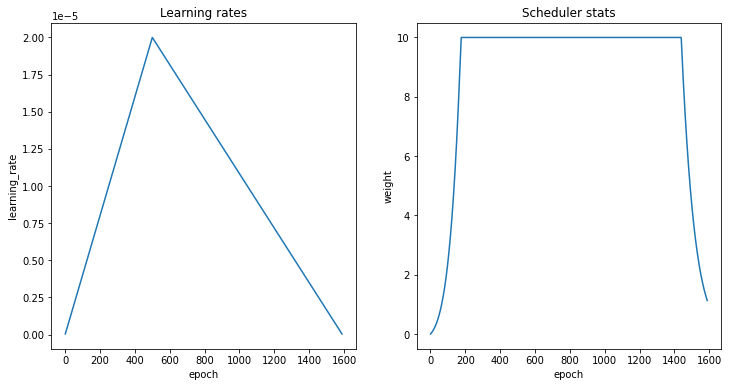

In [60]:
if RETRAIN:
    plot_scheduler_stats({'lr_history': trainer.lr_scheduler.lr_history, 'weights_history': trainer.lr_scheduler.weight_history})

In [61]:
train_features = predict_features_ssl(train_split, TASK)

loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/config.json
Model config DistilBertConfig {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/config.json",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.3,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "id2label": {
    "0": 1.0,
    "1": 1.5,
    "2": 2.0,
    "3": 2.5,
    "4": 3.0,
    "5": 3.5,
    "6": 4.0,
    "7": 4.5,
    "8": 5.0
  },
  "initializer_range": 0.02,
  "label2id": {
    "1.0": 0,
    "1.5": 1,
    "2.0": 2,
    "2.5": 3,
    "3.0": 4,
    "3.5": 5,
    "4.0": 6,
    "4.5": 7,
    "5.0": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hi

  0%|          | 0/2620 [00:00<?, ?ex/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [62]:
test_features = predict_features_ssl(test_split, TASK)

loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/config.json
Model config DistilBertConfig {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/distilbert-base-uncased/cohesion/config.json",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.3,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "id2label": {
    "0": 1.0,
    "1": 1.5,
    "2": 2.0,
    "3": 2.5,
    "4": 3.0,
    "5": 3.5,
    "6": 4.0,
    "7": 4.5,
    "8": 5.0
  },
  "initializer_range": 0.02,
  "label2id": {
    "1.0": 0,
    "1.5": 1,
    "2.0": 2,
    "2.5": 3,
    "3.0": 4,
    "3.5": 5,
    "4.0": 6,
    "4.5": 7,
    "5.0": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hi

  0%|          | 0/1291 [00:00<?, ?ex/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [87]:
best_lgbm = {
    # 'max_bin': 511, 
    'boosting_type': 'gbdt', 
    'subsample_for_bin': 80000, 
    'n_estimators': 700, 
    'max_depth': -1, 
    'min_split_gain': 0.3, 
    'num_leaves': 50, 
    'min_child_samples': 100, 
    'min_child_weight': 1e-05, 
    'reg_alpha': 0.7, 
    'reg_lambda': 0.1, 
    'scale_pos_weight': 150, 
    'learning_rate': 0.005, 
    'device_type': 'gpu', 
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.5, 
    'bagging_freq': 50,
    'verbosity': -1, 
    'objective': 'regression', 
    'metric': 'rmse',
}

In [88]:
RETRAIN = True

In [91]:
if RETRAIN:
    print('Training model regression')

    Path(f'{BASIC_PATH}/models/{MODEL_REG}').mkdir(parents=True, exist_ok=True)

    kfold_predictions, kfold_scores = kfold_train_regression(pd.DataFrame(train_features), y_train[[TASK]].reset_index(drop=True), test_features, config={
        'lgbm': best_lgbm,
        'n_splits': 4,
        'n_repeats': 2,
    }, save_folds=True)

    with open(f'{BASIC_PATH}/models/{MODEL_REG}/trained', 'w') as f:
        f.write(str(datetime.now()))

Training model regression

======================================== Fold: 1 ========================================
Val MCRMSE: 0.4323666705550195
Saving model...
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.

======================================== Fold: 2 ========================================
Val MCRMSE: 0.39381010177005765
Saving model...
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.

======================================== Fold: 3 ========================================
Val MCRMSE: 0.373819216654657
Saving model...
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.

======================================== Fold: 4 ========================================
Val MCRMSE: 0.37556832970127163
Saving model...
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache

In [92]:
predictions = kfold_predict(test_features, {'n_splits': 4, 'n_repeats': 2})


======================================== Fold: 1 ========================================
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.

======================================== Fold: 2 ========================================
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.

======================================== Fold: 3 ========================================
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.

======================================== Fold: 4 ========================================
Initial GPU Usage
GPU memory occupied: 1788 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1788 MB.


In [93]:
np.sqrt(mean_squared_error(y_test[[TASK]], predictions))

0.541592284302612

In [ ]:
submission = pd.DataFrame({k: decode(np.argmax(predictions[k].predictions[0], axis=1)) for k, v in predictions.items()})
submission['text_id'] = y_test['text_id'].reset_index(drop=True)
submission

,cohesion,text_id
0,2.5,772D27D400BB
1,3.0,9E8F3C6405CA
2,4.0,948771F795EB
3,3.5,FE14D7378CFB
4,3.5,7AAE019F70D6
...,...,...
1286,3.0,DB050381035B
1287,2.5,7A0A80926A0D
1288,4.0,FFA6690BC309
1289,3.5,6C98327DA084


In [ ]:
np.sqrt(mean_squared_error(test_split['cohesion'], decode(predictions['cohesion'].label_ids)))

0.0

In [ ]:
submission = pd.DataFrame({k: decode(v.label_ids) for k, v in predictions.items()})
submission['text_id'] = test_data['text_id']
submission

,cohesion,text_id
0,3.0,0000C359D63E
1,3.0,000BAD50D026
2,4.0,00367BB2546B
3,3.0,NaN
4,3.5,NaN
...,...,...
1286,3.5,NaN
1287,2.5,NaN
1288,4.0,NaN
1289,3.5,NaN


In [ ]:
submission.to_csv(f'{BASIC_PATH}/output/submission.csv', index=False)